# データの取得、整形

In [1]:
import sys
sys.path

['d:\\DEV\\competition\\text\\signate_classfication_medical_papers',
 'd:\\masa\\Anaconda3\\python38.zip',
 'd:\\masa\\Anaconda3\\DLLs',
 'd:\\masa\\Anaconda3\\lib',
 'd:\\masa\\Anaconda3',
 '',
 'C:\\Users\\masa\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'd:\\masa\\Anaconda3\\lib\\site-packages',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\geoplot-0.4.1-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\contextily-1.0.0-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\mapclassify-2.3.0-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\descartes-1.1.0-py3.8.egg',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\win32',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'd:\\masa\\Anaconda3\\lib\\site-packages\\Pythonwin']

In [2]:
import pandas as pd
pd.options.display.max_colwidth = None

In [3]:
df = pd.read_csv("train.csv", index_col=0)

In [4]:
df["feature"] = df["title"] + df["abstract"].fillna("")

In [5]:
df["abstract"]=df["abstract"].where(df["abstract"].notna(),df["title"])

In [6]:
df.head()

,title,abstract,judgement,feature
id,,,,
0,One-year age changes in MRI brain volumes in older adults.,Longitudinal studies indicate that declines in cognition and memory accelerate after age 70 years. The neuroanatomic and neurophysiologic underpinnings of cognitive change are unclear as there is little information on longitudinal brain changes. We are conducting a longitudinal neuroimaging study of nondemented older participants in the Baltimore Longitudinal Study of Aging. This report focuses on age and sex differences in brain structure measured by magnetic resonance imaging during the first two annual evaluations. Cross-sectional results from 116 participants aged 59-85 years reveal significantly larger ventricular volumes and smaller gray and white matter volumes in older compared with younger participants and in men compared with women. Regional brain volumes show that the effects of age and sex are not uniform across brain regions. Age differences are greatest for the parietal region. Sex differences tend to be larger for frontal and temporal than parietal and occipital regions. Longitudinal analysis demonstrates an increase of 1526 mm(3) in ventricular volume over 1 year but no detectable change in total or regional brain volumes. Definition of the pattern and rate of longitudinal brain changes will facilitate the detection of pathological brain changes which may be predictors of dementia.,0,One-year age changes in MRI brain volumes in older adults.Longitudinal studies indicate that declines in cognition and memory accelerate after age 70 years. The neuroanatomic and neurophysiologic underpinnings of cognitive change are unclear as there is little information on longitudinal brain changes. We are conducting a longitudinal neuroimaging study of nondemented older participants in the Baltimore Longitudinal Study of Aging. This report focuses on age and sex differences in brain structure measured by magnetic resonance imaging during the first two annual evaluations. Cross-sectional results from 116 participants aged 59-85 years reveal significantly larger ventricular volumes and smaller gray and white matter volumes in older compared with younger participants and in men compared with women. Regional brain volumes show that the effects of age and sex are not uniform across brain regions. Age differences are greatest for the parietal region. Sex differences tend to be larger for frontal and temporal than parietal and occipital regions. Longitudinal analysis demonstrates an increase of 1526 mm(3) in ventricular volume over 1 year but no detectable change in total or regional brain volumes. Definition of the pattern and rate of longitudinal brain changes will facilitate the detection of pathological brain changes which may be predictors of dementia.
1,Supportive CSF biomarker evidence to enhance the National Institute on Aging-Alzheimer's Association criteria for diagnosis of Alzheimer's type dementia--a study from Southern India.,The present study was undertaken to validate the measurement of biomarkers as a supplement to the latest diagnostic criteria for Alzheimer disease (AD) dementia by National Institute on Aging-Alzheimer's Association (NIA-AA) work group using a sample attending a tertiary care center in Southern India. A total of 20 subjects diagnosed clinically as Alzheimer's dementia according to the NIA-AA criteria for AD were included in the study. The CSF biomarkers Aﾎｲ42 t-tau and p-tau181 were assessed. The biomarker results were compared among mild and moderate to severe AD as defined in the NIA-AA work group guidelines. The results revealed that the amount of Aﾎｲ42 was very low in all the 20 samples (<50pg/ml) collected from mild AD cases with CDR score of 1 (n=8) and moderate to severe AD cases with CDR >1 (n=12). t-tau and p-tau levels were in the range of 39.45ﾂｱ5.09pg/ml and 13.06ﾂｱ7.32pg/ml for CDR 1 group. t-tau and p-tau levels were in the range of 49.9ﾂｱ11.28pg/ml and 33.94ﾂｱ15.13pg/ml for moderate to

In [7]:
len(df)

27145

## インストール

In [8]:
#!pip install ipython -U

In [9]:
# ライブラリのインストール
#!python -m pip install --upgrade pip
#!pip install -U fugashi ipadic \
#    transformers lime captum\
#    scikit-learn numpy --user


# データローラーなど

In [10]:
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'feature': row.feature,
                'judgement': row.judgement
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

train_df, eval_df = train_test_split(df, train_size=0.8)
#eval_df, test_df = train_test_split(eval_df, train_size=0.5)

train_dataset = CustomDataset(train_df)
eval_dataset = CustomDataset(eval_df)
#test_dataset = CustomDataset(test_df)

100%|██████████| 5429/5429 [00:00<00:00, 493656.13it/s]


In [66]:
train_dataset.__dict__

{'features': [{'feature': "The lack of expression of the peripheral benzodiazepine receptor characterises microglial response in anaplastic astrocytomasThe peripheral benzodiazepine receptor (PBR) is a 18 kDa molecule mainly involved in cholesterol transport through the mitochondrial membrane. In microglia  PBR is expressed from the earliest stages of activation and appears to exert a pro-inflammatory function. This molecule is commonly up-regulated in inflammatory  degenerative  infective and ischaemic lesions of the central nervous system but it has never been reported in glioma-infiltrating microglia. We examined two anaplastic astrocytomas showing minimal contrast-enhancement and therefore little damage of the blood brain barrier to minimise the presence of blood borne macrophages within tumour tissue. The two lesions were studied in vivo using positron emission tomography (PET) with the specific PBR ligand [11C](R)-PK11195 and the corresponding tumour tissue was investigated with 

In [11]:
import collections

l = train_df.judgement

c = collections.Counter(l)
print(c)

Counter({0: 21214, 1: 502})


In [12]:
import collections

l = eval_df.judgement

c = collections.Counter(l)
print(c)

Counter({0: 5299, 1: 130})


In [68]:
import torch
from transformers import AutoTokenizer

class CustomCollator():
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __call__(self, examples):
        if 'judgement' in examples:
            examples = {
                'feature': list(map(lambda x: x['feature'], examples)),
                'judgement': list(map(lambda x: x['judgement'], examples))
            }
        else:
            examples = {
                'feature': list(map(lambda x: x['feature'], examples))
            }
        encodings = self.tokenizer(examples['feature'],
                                   padding=True,
                                   truncation=True,
                                   max_length=self.max_length,
                                   return_tensors='pt')
        if 'judgement' in examples:
            encodings['judgement'] = torch.tensor(examples['judgement'])
        return encodings
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = AutoTokenizer.from_pretrained('sultan/BioM-ELECTRA-Base-Generator')
custom_collator = CustomCollator(tokenizer)

loading configuration file config.json from cache at C:\Users\masa/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\masa/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\vocab.txt

In [69]:
# ライブラリのインポート
import os
import re
import sys

from captum.attr import visualization as viz
from captum.attr import LayerIntegratedGradients
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
from torch.nn import functional as F
import transformers
from sklearn.model_selection import train_test_split

In [70]:
# BERTモデルの動作デバイス
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Function
import numpy as np


class FocalLossWithOutOneHot(nn.Module):
    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLossWithOutOneHot, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        logit = F.softmax(input, dim=1)
        logit = logit.clamp(self.eps, 1. - self.eps)
        logit_ls = torch.log(logit)
        loss = F.nll_loss(logit_ls, target, reduction="none")
        view = target.size() + (1,)
        index = target.view(*view)
        loss = loss * (1 - logit.gather(1, index).squeeze(1)) ** self.gamma # focal loss
        return loss.sum()

In [72]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5,
    #weight=True, size_average=True,
    ):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        

    def forward(self, target, preds, smooth=1):
        #print(preds)
        #print(target)
        preds = F.one_hot(preds, num_classes=2)
        
        softmax_fn = nn.Softmax(dim=1)
        target = softmax_fn(target)
        #target = torch.sigmoid(target) 
        #print(target)
        
        #flatten label and preds tensors
        preds = preds.reshape(-1)
        target = target.reshape(-1)
        
        #True Positives, False Positives & False Negatives 
        TP = (preds * target).sum()
        FP = ((1-target) * preds).sum()
        FN = (target * (1-preds)).sum()
        Tversky = (TP + smooth)/(TP + self.alpha*FP + self.beta*FN + smooth)
        return Tversky 

In [83]:
import torch.nn as nn
from transformers import AutoModel
from transformers import BertForSequenceClassification
from transformers.modeling_outputs import ModelOutput

class CustomNet(nn.Module):
    def __init__(self, pretrained_model, num_categories, loss_function=None):
        super().__init__()
        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size
        self.linear = nn.Linear(self.hidden_size, num_categories)
        self.loss_function = loss_function
    
    def forward(self,
                input_ids,
                attention_mask=None,
                position_ids=None,
                token_type_ids=None,
                output_attentions=False,
                output_hidden_states=False,
                judgement=None):
        
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            position_ids=position_ids,
                            token_type_ids=token_type_ids,
                            output_attentions=output_attentions,
                            output_hidden_states=output_hidden_states)
        print(outputs)
        state = outputs.last_hidden_state[:, 0, :]
        state = self.linear(state)
        
        loss=None
        print(judgement)
        print(self.loss_function)
        if judgement is not None and self.loss_function is not None:
            loss = self.loss_function(state, judgement)
        
        attentions=None
        if output_attentions:
            attentions=outputs.attentions
        
        hidden_states=None
        if output_hidden_states:
            hidden_states=outputs.hidden_states
        print(loss)
        return ModelOutput(
            logits=state,
            loss=loss,
            last_hidden_state=outputs.last_hidden_state,
            attentions=attentions,
            hidden_states=hidden_states
        )

categories = [0,1]
loss_fct = FocalLossWithOutOneHot()
loss_fct = nn.CrossEntropyLoss()
#loss_fct = TverskyLoss(alpha=0.3,beta=0.7) 
#pretrained_model = AutoModel.from_pretrained('sultan/BioM-ELECTRA-Base-Generator')
#pretrained_model = AutoModel.from_pretrained('bert-base-uncased')
pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
#pretrained_model = BertForSequenceClassification.from_pretrained('sultan/BioM-ELECTRA-Base-Generator')
model = CustomNet(pretrained_model, len(categories), loss_fct)

loading configuration file config.json from cache at C:\Users\masa/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\masa/.cache\huggingface\hub\models--bert-base-uncased\snapshots\5546055f03398095e385d7dc625e636cc8910bf2\pytorch_model.bin
Some weights of

In [22]:
import torch.nn as nn
from transformers import AutoModel
from transformers import BertForSequenceClassification
from transformers.modeling_outputs import ModelOutput

class CustomNetForClassification(nn.Module):
    def __init__(self, pretrained_model, num_categories, loss_function=None):
        super().__init__()
        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size
        self.linear = nn.Linear(self.hidden_size, num_categories)
        self.loss_function = loss_function
    
    def forward(self,
                input_ids,
                attention_mask=None,
                position_ids=None,
                token_type_ids=None,
                output_attentions=False,
                output_hidden_states=False,
                judgement=None):
        
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            position_ids=position_ids,
                            token_type_ids=token_type_ids,
                            output_attentions=output_attentions,
                            output_hidden_states=output_hidden_states)

        #state = outputs.last_hidden_state[:, 0, :]
        #state = self.linear(state)
        state = outputs
        
        loss=None
        #print(judgement)
        #print(self.loss_function)
        if judgement is not None and self.loss_function is not None:
            loss = self.loss_function(state, judgement)
        
        attentions=None
        if output_attentions:
            attentions=outputs.attentions
        
        hidden_states=None
        if output_hidden_states:
            hidden_states=outputs.hidden_states
            
        return ModelOutput(
            logits=state,
            loss=loss,
            #last_hidden_state=outputs.last_hidden_state,
            attentions=attentions,
            hidden_states=hidden_states
        )

categories = [0,1]
loss_fct = FocalLossWithOutOneHot()

#loss_fct = TverskyLoss(alpha=0.3,beta=0.7) 
#pretrained_model = AutoModel.from_pretrained('sultan/BioM-ELECTRA-Base-Generator')
pretrained_model = BertForSequenceClassification.from_pretrained('sultan/BioM-ELECTRA-Base-Generator')
model = CustomNetForClassification(pretrained_model, len(categories), loss_fct)

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at sultan/BioM-ELECTRA-Base-Generator were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.4.attention.self.query.bias', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.7.output.dense.bias', 'electra.encoder.layer.10.attention.self.key.weight', 'electra.encoder.layer.2.attention.self.query.bias', 'electra.encoder.layer.5.output.LayerNorm.weight', 'electra.encoder.layer.7.attention.output.dense.weight', 'electra.encoder.layer.8.output.dense.bias', 'electra.encoder.layer.11.output.LayerNorm.bias', 'electra.encoder.layer.10.attention.self.query.weight', 'electra.encoder.layer.6.attention.self.query.weight', 'electra.encoder.layer.6.output.LayerNorm.weight', 'electra.encoder.layer.0.output.LayerNorm.bias', 'electra.encoder.layer.10.attention

In [148]:
#model.load_state_dict(torch.load("output\model\prod\pytorch_model.bin"))

In [84]:
model

CustomNet(
  (bert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [92]:
"""
for name,param in model.named_parameters():
    param.requires_grad = False

#BERTの最上位層（１２層目）とその下の層（11層目）をアクティブにする
for name, param in model.bert.encoder.layer[11].named_parameters():
    param.requires_grad = True

for name, param in model.bert.encoder.layer[10].named_parameters():
    param.requires_grad = True
"""
#sultan/BioM-ELECTRA-Base-Generator
for name,param in model.named_parameters():
    param.requires_grad = False

#BERTの最上位層（１２層目）とその下の層（11層目）をアクティブにする
for name, param in model.bert.bert.encoder.layer[11].named_parameters():
    param.requires_grad = True

for name, param in model.bert.bert.encoder.layer[10].named_parameters():
    param.requires_grad = True



In [93]:

model = model.to(device)

# Fine tunining

In [94]:
optimizer = transformers.AdamW(model.parameters(), lr=1e-3)

In [95]:
from transformers import EvalPrediction
from typing import Dict
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

def custom_compute_metrics(res: EvalPrediction) -> Dict:
    # res.predictions, res.label_idsはnumpyのarray
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    fbeta = fbeta_score(target, pred, beta = 7, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fbeta' : fbeta
    }

In [96]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./output/model',
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    label_names=['judgement'],
    lr_scheduler_type='polynomial',
    metric_for_best_model='fbeta',
    load_best_model_at_end=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    remove_unused_columns=False
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [97]:
model

CustomNet(
  (bert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [98]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=custom_collator,
    compute_metrics=custom_compute_metrics,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)



In [99]:
trainer.train(ignore_keys_for_eval=['last_hidden_state', 'hidden_states', 'attentions'])
trainer.save_model("output/model/sultan/BioM-ELECTRA-Base-Generator")

***** Running training *****
  Num examples = 21716
  Num Epochs = 100
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 135800


  0%|          | 0/135800 [00:00<?, ?it/s]

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0009, -0.0249],
        [ 0.3293,  0.1460],
        [-0.0300, -0.1127],
        [ 0.2281, -0.1183],
        [ 0.1591, -0.1246],
        [ 0.0528, -0.0578],
        [ 0.0282,  0.0521],
        [ 0.2465,  0.2559],
        [-0.0140, -0.3003],
        [ 0.2354,  0.1543],
        [-0.0801, -0.0654],
        [-0.0148, -0.0034],
        [ 0.0452,  0.0643],
        [ 0.0628, -0.1094],
        [ 0.0680,  0.0142],
        [ 0.2140, -0.0051]], device='cuda:0', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)


AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

In [ ]:
categories = [0,1]


In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

preds_output = trainer.predict(eval_dataset, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(eval_df["judgement"])



***** Running Prediction *****
  Num examples = 5429
  Batch size = 16


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/40834 [1:05:01<?, ?it/s]


KeyboardInterrupt: 

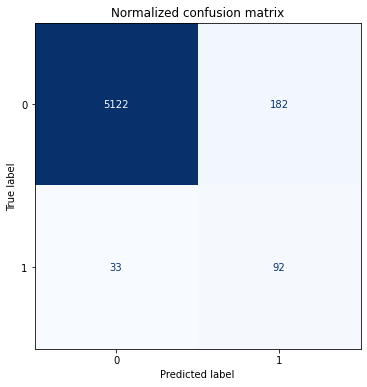

In [ ]:
def plot_confusion_matrix(y_preds, y_true, categories):
    cm = confusion_matrix(y_true, y_preds, normalize=None)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, categories)

In [ ]:
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class TestDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'feature': row.feature
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

test_df = pd.read_csv("test.csv", index_col=0)
test_df["feature"]=test_df["abstract"].where(test_df["abstract"].notna(),test_df["title"])

test_dataset = TestDataset(test_df)




100%|██████████| 40834/40834 [00:00<00:00, 870536.44it/s]


In [ ]:
test_df

,title,abstract,feature
id,,,
27145,Estimating the potential effects of COVID-19 pandemic on food commodity prices and nutrition security in Nepal,"The objective of the paper is to analyse changes in food commodity prices and estimate the potential effects of food price change on nutrition security in Nepal in the context of COVID-19 contagion control measures. It presents a comparative intra-country observational study design looking at events before and during the pandemic (after implementation of contagion control measures). The study design includes three districts, enabling comparison between diverse agroecological zones and geographical contexts. The methodology consists of primary data collection, modelling and quantitative analysis. The analysis is based on actual school meal food baskets which represent culturally and nutritionally optimised food baskets, developed by the local community and notional typical household food baskets. End May/early June 2020 is the 'Post COVID 19' reference point, the same time period in 2019 i.e. June 2019 is the 'Pre COVID 19' reference point. The study finds substantial increase in food commodity prices across food groups and districts with marked inter-district variation. For school meal basket, all micronutrients show large average declines ranging from 9.5% for zinc to 11% for vitamin A. For household food baskets on average, vitamin-A reduced 37% followed by iron at 19%, reduction in zinc is low due to the high zinc content in whole grain cereals. COVID-19 control measures are likely to have contributed to substantial price inflation over the reference period with potentially damaging effects on nutrition security in Nepal with serious implications for vulnerable populations.Copyright Â© 2020 Cambridge University Press. All rights reserved.","The objective of the paper is to analyse changes in food commodity prices and estimate the potential effects of food price change on nutrition security in Nepal in the context of COVID-19 contagion control measures. It presents a comparative intra-country observational study design looking at events before and during the pandemic (after implementation of contagion control measures). The study design includes three districts, enabling comparison between diverse agroecological zones and geographical contexts. The methodology consists of primary data collection, modelling and quantitative analysis. The analysis is based on actual school meal food baskets which represent culturally and nutritionally optimised food baskets, developed by the local community and notional typical household food baskets. End May/early June 2020 is the 'Post COVID 19' reference point, the same time period in 2019 i.e. June 2019 is the 'Pre COVID 19' reference point. The study finds substantial increase in food commodity prices across food groups and districts with marked inter-district variation. For school meal basket, all micronutrients show large average declines ranging from 9.5% for zinc to 11% for vitamin A. For household food baskets on average, vitamin-A reduced 37% followed by iron at 19%, reduction in zinc is low due to the high zinc content in whole grain cereals. COVID-19 control measures are likely to have contributed to substantial price inflation over the reference period with potentially damaging effects on nutrition security in Nepal with serious implications for vulnerable populations.Copyright Â© 2020 Cambridge University Press. All rights reserved."
27146,Leukoerythroblastic reaction in a patient with COVID-19 infection,NaN,Leukoerythroblastic reaction in a patient with COVID-19 infection
27147,[15O]-water PET and intraoperative brain mapping: A comparison in the localization of eloquent cortex,[15O]-water PET was performed on 12 patients with structural lesions for localization of the motor (r\ = 5) language (receptive and expressive; n = 6) and visual cortex (h = 1). All these patients underwent interactive image-guided surgery using an infrared d

In [ ]:
result = trainer.predict(test_dataset, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])

***** Running Prediction *****
  Num examples = 40834
  Batch size = 16


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

In [ ]:
test_df["label"] = result.predictions.argmax(axis=1).tolist()

In [ ]:
test_df.head()

,title,abstract,feature,label
id,,,,
27145,Estimating the potential effects of COVID-19 pandemic on food commodity prices and nutrition security in Nepal,"The objective of the paper is to analyse changes in food commodity prices and estimate the potential effects of food price change on nutrition security in Nepal in the context of COVID-19 contagion control measures. It presents a comparative intra-country observational study design looking at events before and during the pandemic (after implementation of contagion control measures). The study design includes three districts, enabling comparison between diverse agroecological zones and geographical contexts. The methodology consists of primary data collection, modelling and quantitative analysis. The analysis is based on actual school meal food baskets which represent culturally and nutritionally optimised food baskets, developed by the local community and notional typical household food baskets. End May/early June 2020 is the 'Post COVID 19' reference point, the same time period in 2019 i.e. June 2019 is the 'Pre COVID 19' reference point. The study finds substantial increase in food commodity prices across food groups and districts with marked inter-district variation. For school meal basket, all micronutrients show large average declines ranging from 9.5% for zinc to 11% for vitamin A. For household food baskets on average, vitamin-A reduced 37% followed by iron at 19%, reduction in zinc is low due to the high zinc content in whole grain cereals. COVID-19 control measures are likely to have contributed to substantial price inflation over the reference period with potentially damaging effects on nutrition security in Nepal with serious implications for vulnerable populations.Copyright Â© 2020 Cambridge University Press. All rights reserved.","The objective of the paper is to analyse changes in food commodity prices and estimate the potential effects of food price change on nutrition security in Nepal in the context of COVID-19 contagion control measures. It presents a comparative intra-country observational study design looking at events before and during the pandemic (after implementation of contagion control measures). The study design includes three districts, enabling comparison between diverse agroecological zones and geographical contexts. The methodology consists of primary data collection, modelling and quantitative analysis. The analysis is based on actual school meal food baskets which represent culturally and nutritionally optimised food baskets, developed by the local community and notional typical household food baskets. End May/early June 2020 is the 'Post COVID 19' reference point, the same time period in 2019 i.e. June 2019 is the 'Pre COVID 19' reference point. The study finds substantial increase in food commodity prices across food groups and districts with marked inter-district variation. For school meal basket, all micronutrients show large average declines ranging from 9.5% for zinc to 11% for vitamin A. For household food baskets on average, vitamin-A reduced 37% followed by iron at 19%, reduction in zinc is low due to the high zinc content in whole grain cereals. COVID-19 control measures are likely to have contributed to substantial price inflation over the reference period with potentially damaging effects on nutrition security in Nepal with serious implications for vulnerable populations.Copyright Â© 2020 Cambridge University Press. All rights reserved.",0
27146,Leukoerythroblastic reaction in a patient with COVID-19 infection,NaN,Leukoerythroblastic reaction in a patient with COVID-19 infection,0
27147,[15O]-water PET and intraoperative brain mapping: A comparison in the localization of eloquent cortex,[15O]-water PET was performed on 12 patients with structural lesions for localization of the motor (r\ = 5) language (receptive and expressive; n = 6) and visual cortex (h = 1). All these patients underwent interactive image-guided surgery using an

In [ ]:
import collections

l = test_df["label"] 

c = collections.Counter(l)
print(c)

Counter({0: 38850, 1: 1984})


In [ ]:

#test_df=test_df.drop('title', axis=1)
#test_df=test_df.drop('abstract', axis=1)
test_df=test_df.drop('feature', axis=1)

In [ ]:
test_df.to_csv('submit_SapBERT.csv', header=False )

In [97]:
len(result.predictions.argmax(axis=1).tolist())

40834

In [93]:
result.predictions.argmax(axis=1).tolist()

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [81]:
softmax_fn = nn.Softmax(dim=1)
softmax_output = softmax_fn(result[0])

AttributeError: 'numpy.ndarray' object has no attribute 'softmax'

In [123]:
trainer.save_model("output/model/prod")

Saving model checkpoint to output/model/prod
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in output/model/prod\tokenizer_config.json
Special tokens file saved in output/model/prod\special_tokens_map.json


In [125]:
class SubmitDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'abstract': row.abstract
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

In [138]:
submit_df = pd.read_csv("test.csv", index_col=0)
submit_df["abstract"]=submit_df["abstract"].where(submit_df["abstract"].notna(),submit_df["title"])
submit_df['judgement'] = [0] * len(submit_df)
submit_dataset = CustomDataset(submit_df)



100%|██████████| 40834/40834 [00:00<00:00, 314942.63it/s]


In [135]:
submit_df["abstract"]=submit_df["abstract"].where(submit_df["abstract"].notna(),submit_df["title"])

In [139]:
submit_df

,title,abstract,judgement
id,,,
27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...,0
27146,Leukoerythroblastic reaction in a patient with...,Leukoerythroblastic reaction in a patient with...,0
27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...,0
27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...,0
27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...,0
...,...,...,...
67974,"Knowledge, Attitude, and Practices of Healthca...",In the current outbreak of novel coronavirus (...,0
67975,Safety and Efficacy of Anti-Il6-Receptor Tocil...,BACKGROUND: As the novel SARS-CoV-2 pandemic o...,0
67976,Functional imaging of head and neck tumors usi...,Positron emission tomography (PET) is an imagi...,0


In [140]:
result = trainer.predict(submit_dataset, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])

***** Running Prediction *****
  Num examples = 40834
  Batch size = 8


  0%|          | 0/5105 [00:00<?, ?it/s]

d:\masa\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


: 

In [73]:
result

PredictionOutput(predictions=array([[ 5.5383935, -5.2530723],
       [ 3.457717 , -2.8394465]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.7026, 'test_samples_per_second': 2.846, 'test_steps_per_second': 1.423})

AttributeError: 'numpy.ndarray' object has no attribute 'softmax'

In [72]:
result[0]

array([[ 5.5383935, -5.2530723],
       [ 3.457717 , -2.8394465]], dtype=float32)

In [22]:
import pandas as pd
import os

df = pd.read_pickle('./input/livedoor_data.pickle')
# カテゴリーのID列を付与しておく
categories = df['category'].unique().tolist()
category2id = {cat: categories.index(cat) for cat in categories}
df['category_id'] = df['category'].map(lambda x: category2id[x])

df.sample(3)

FileNotFoundError: [Errno 2] No such file or directory: './input/livedoor_data.pickle'